Available datasets: dict_keys(['autos', 'concrete', 'customer', 'accidents'])


C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\envs\env_mlf\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\spyder_kernels\customize\spydercustomize.py", line 47, in __init__
    super(SubprocessPopen, self).__init__(*args, **kwargs)
  File "C:\Users\user\anaconda3\envs\e

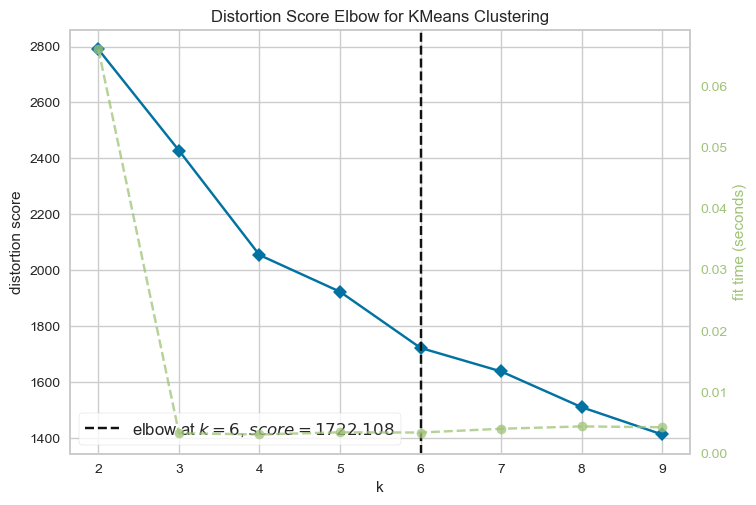

Оптимальна кількість кластерів: 6


C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


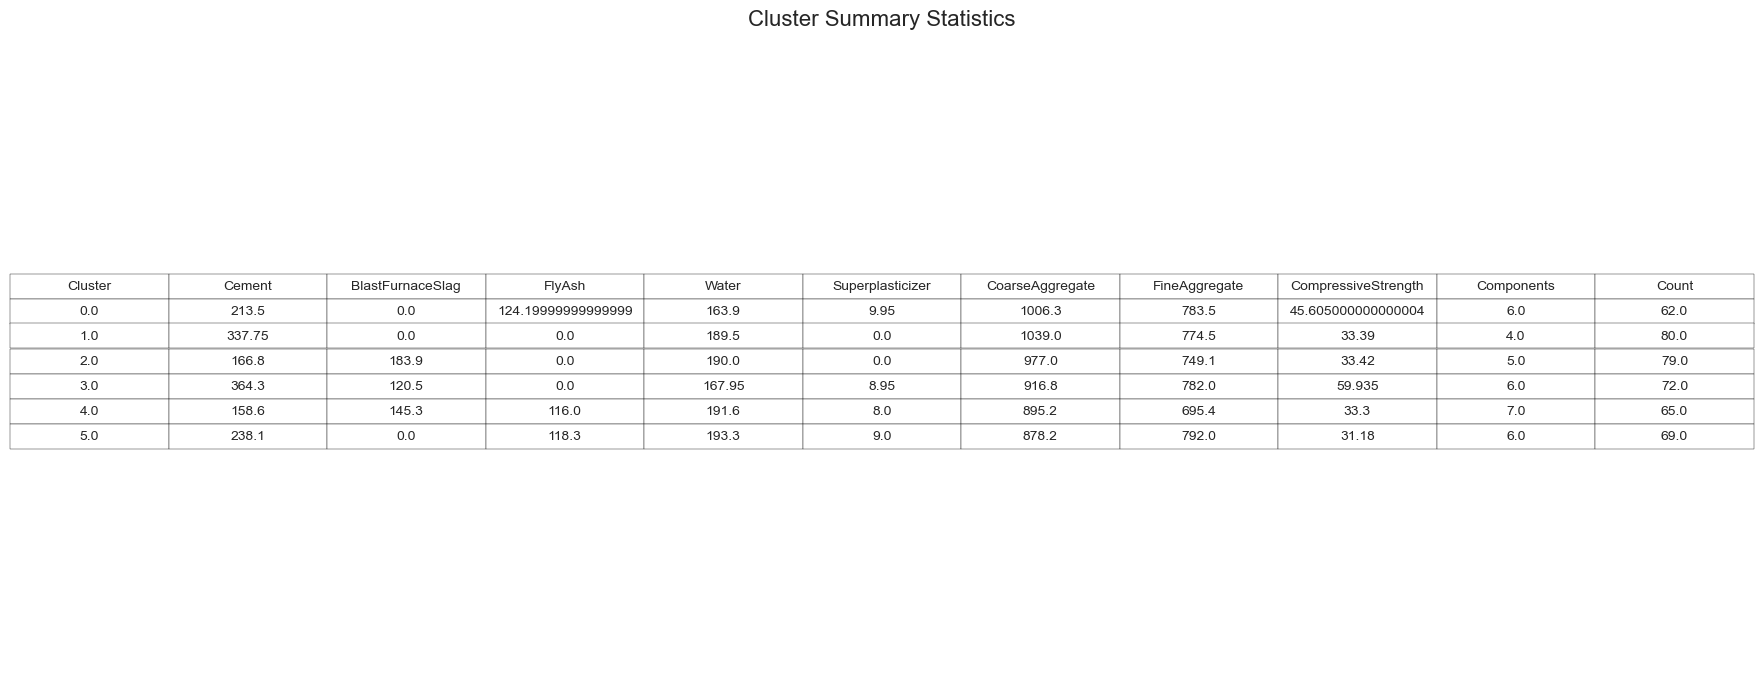

   Cluster  Cement  BlastFurnaceSlag  ...  CompressiveStrength  Components  Count
0        0  213.50               0.0  ...               45.605         6.0     62
1        1  337.75               0.0  ...               33.390         4.0     80
2        2  166.80             183.9  ...               33.420         5.0     79
3        3  364.30             120.5  ...               59.935         6.0     72
4        4  158.60             145.3  ...               33.300         7.0     65
5        5  238.10               0.0  ...               31.180         6.0     69

[6 rows x 11 columns]


In [2]:
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# %% Завантаження файлу
with open('../datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

# Перевірка доступних даних
print("Available datasets:", datasets.keys())

# %% Вибір датасету 'concrete'
data = datasets['concrete']

# %% Створення нової ознаки 'Components' — кількість задіяних складових у рецептурі бетону
data['Components'] = (data.iloc[:, :-1] > 0).sum(axis=1)

# %% Видалення (дроп) зайвих колонок перед нормалізацією
features = data.drop(columns=['Components', 'Cluster'], errors='ignore')

# %% Нормалізація даних
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)

# %% Визначення оптимальної кількості кластерів за допомогою KElbowVisualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(data_scaled)
visualizer.show()

# %% Визначення оптимальної кількості кластерів
optimal_clusters = visualizer.elbow_value_
print(f"Оптимальна кількість кластерів: {optimal_clusters}", flush=True)

# %% Проведення кластеризації методом k-середніх
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Розрахунок описової статистики для кожного кластеру
cluster_stats = data.groupby('Cluster').median()

# Додавання кількості об'єктів у кожному кластері
cluster_stats['Count'] = data['Cluster'].value_counts()

# Додавання кількості компонентів у кожному кластері
components_stats = data.groupby('Cluster')['Components'].sum()
# cluster_stats['Total Components'] = components_stats

# Перетворення статистики у формат таблиці
cluster_summary = cluster_stats.reset_index()

# Виведення таблиці за допомогою matplotlib
fig, ax = plt.subplots(figsize=(15, 8))  # Розмір графіка
ax.axis('tight')
ax.axis('off')

# %% Створення таблиці на основі DataFrame
table = ax.table(cellText=cluster_summary.values,
                 colLabels=cluster_summary.columns,
                 cellLoc='center',
                 loc='center')

# Оформлення таблиці
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)

# Відображення таблиці
plt.title("Cluster Summary Statistics", fontsize=16, pad=20)
plt.show()

# Вивід підсумкової таблиці
print(cluster_summary)

In [ ]:
print(''' ВИСНОВКИ:
    
\n1. Виходячи з наведених кластерів та їхніх статистичних характеристик, можна 
зробити такі висновки:

Кількість кластерів: Оптимальна кількість кластерів для кластеризації бетону — 6,
що підтверджується методом KElbowVisualizer.

\n2.Основні складові:
Кластери демонструють різну комбінацію основних інгредієнтів (цемент, шлак, 
зола, вода, суперпластифікатор, тощо), що впливають на кінцеву міцність бетону.
Наприклад, у кластері 0 присутній вищий вміст золи (124.2), а в кластері 
3 — максимальна концентрація цементу (364.3).

\n3.Міцність на стиск:
Кластер 3 має найвищу середню міцність на стиск (59.94), що пов’язано з великою
кількістю цементу.
Кластери 1, 2, 4, та 5 мають відносно нижчу міцність на стиск (~31-33), що 
свідчить про більш стандартну рецептуру.

\n4.Кількість компонентів:
Кластери відрізняються за кількістю задіяних компонентів. Наприклад, кластер 4 
використовує всі 7 компонентів, що може свідчити про більш складний рецепт, 
тоді як кластер 1 використовує лише 4 компоненти.

\n5.Кількість зразків у кластерах:
Кластер 1 має найбільшу кількість зразків (80), тоді як кластер 0 — найменшу (62),
що може свідчити про різну популярність рецептів у кожному кластері.

Таким чином, кожен кластер відображає певний набір рецептів бетону, що 
впливають на міцність, вартість та інші властивості матеріалу. Найвищу 
міцність на стиск демонструє кластер 3, завдяки збалансованому складу. ''')

# %%